(Visit the
[documentation](https://datafold-dev.gitlab.io/datafold/tutorial_index.html) page
to view the executed notebook.)

# Koopman Operator for Model Predictive Control
**In this tutorial** we introduce the usage of Koopman operators and the Dynamic Mode Decomposition method with controlled systems, as well as demonstrate how Koopman-based models cn be applied to model predictive control.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
from datafold.appfold import EDMD
from datafold.appfold.kmpc import AffineKgMPC, LinearKMPC
from datafold.dynfold import DMDControl, gDMDAffine
from datafold.dynfold.transform import TSCIdentity, TSCRadialBasis
from datafold.pcfold import InitialCondition, InverseQuadraticKernel, TSCDataFrame

## Data generation

### Inverted pendulum Physics
A test model implemented in datafold is used to generate example data in this tutorial. A pendulum and a moving cart are connected by a swivel, which allows the pendulum to freely rotate. The cart wheels spin on a rail, and the entire system is powered by a DC motor. The displacement of the cart $x$ and the angular rotation of the pendulum $\theta$ describe the movement of the pendulum (note that the time derivatives, $\dot x$ and $\dot \theta$, are also needed to describe the full state), and the voltage to the motor $u$ can be controlled.

In [3]:
from datafold.utils._systems import InvertedPendulum

state_cols = ["x", "xdot", "theta", "thetadot"]
control_cols = ["u"]

### Creating the training set
The training set will consists of 20 different trajectories of 10 seconds each, discretized at 0.01 s time steps. The initial conditions of all trajectories is the same, and the control input is a sinusoidal signal of varying amplitude, frequency and phase. The 20 timeseries are concatenated into a `TSCDataFrame`.

In [4]:
# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20  # -
ic = InitialCondition.from_array(np.array([0, 0, 0, 0]), time_value=0, feature_names=state_cols)

In [5]:
invertedPendulum = InvertedPendulum(initial_condition=ic.values)

Xlist, Ulist = [], []
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9 * np.random.random()
    control_frequency = np.pi + 2 * np.pi * np.random.random()
    control_phase = 2 * np.pi * np.random.random()
    control_func = lambda t, y: control_amplitude * np.sin(
        control_frequency * t + control_phase
    )
    invertedPendulum.reset()
    traj = invertedPendulum.predict(
        time_step=sim_time_step,
        num_steps=sim_num_steps,
        control_func=control_func,
    )
    assert (
        invertedPendulum.sol.success
    ), f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=state_cols)
    dfx[control_cols] = 0.0
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=control_cols)
    for col in state_cols:
        dfu[col] = 0.0
    dfu = dfu[state_cols + control_cols]
    Ulist.append(dfu)

X_tsc = TSCDataFrame.from_frame_list(Xlist)[state_cols]
X_tsc[control_cols] = TSCDataFrame.from_frame_list(Ulist)[control_cols]
X_tsc

feature          x      xdot     theta  thetadot         u
ID time                                                   
0  0.00   0.000000  0.000000  0.000000  0.000000 -0.434292
   0.01  -0.000140 -0.027528 -0.000384 -0.075455 -0.436980
   0.02  -0.000540 -0.052035 -0.001482 -0.142833 -0.436041
   0.03  -0.001171 -0.073632 -0.003215 -0.202622 -0.431481
   0.04  -0.002004 -0.092419 -0.005510 -0.255252 -0.423339
...            ...       ...       ...       ...       ...
19 9.96  -0.008283 -0.169155  1.873889  1.732390 -0.276201
   9.97  -0.009982 -0.170643  1.892499  1.989419 -0.275695
   9.98  -0.011697 -0.172294  1.913673  2.244975 -0.274865
   9.99  -0.013429 -0.174106  1.937393  2.498746 -0.273712
   10.00 -0.015179 -0.176075  1.963641  2.750378 -0.272238

[20020 rows x 5 columns]

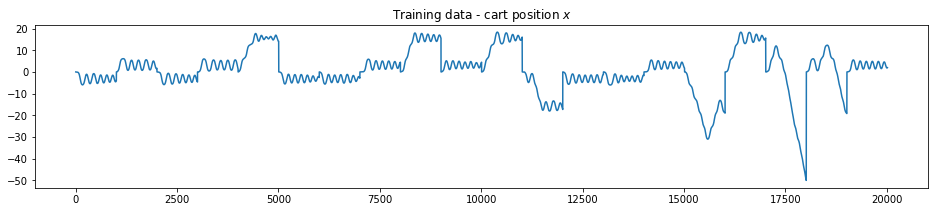

In [6]:
plt.figure(figsize=(16, 3))
plt.plot(X_tsc["theta"].values)
plt.title(r"Training data - cart position $x$");

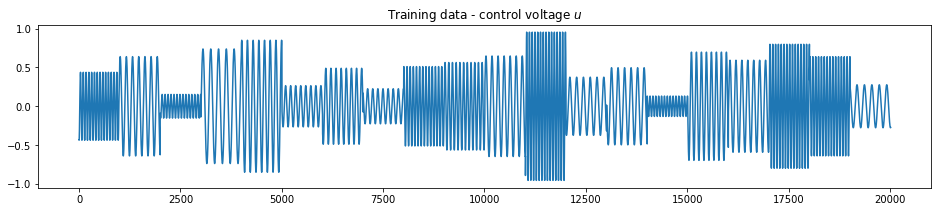

In [7]:
plt.figure(figsize=(16, 3))
plt.plot(X_tsc["u"].values)
plt.title(r"Training data - control voltage $u$");

## Estimators used to model the system 

### Linear Control DMD predictor
In this section we demonstrate how to use the `DMDControl` class to create a Dynamic mode decomposition predictor for controlled systems using the data above.

The `DMDControl` class implements the `TSCPredictMixin` which is based on `scikit-learn` estimator-style interface. First we need to initialize the class and indicate which features will describe the state and which features the control input. Then we can use the `.fit` method to train the model, which in practice means finding $A$ and $B$ matrices which best satisfy $z^+ = Az + Bu$ ($z$ here refering to the state vector of the system). This estimator assumes that the system is linear in both the state and the control input.  

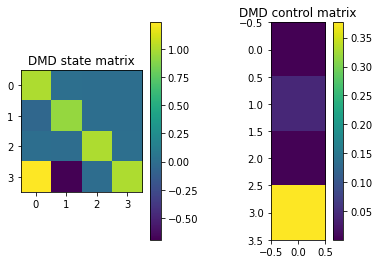

In [8]:
dmdc = DMDControl()
dmdc.fit(X_tsc[state_cols], U=X_tsc[control_cols])

plt.subplot(121)
plt.imshow(dmdc.sys_matrix_)
plt.colorbar()
plt.title("DMD state matrix")
plt.subplot(122)
plt.imshow(dmdc.control_matrix_)
plt.colorbar()
plt.title("DMD control matrix");

The `.predict` method can be used to estimate the trajectory of the system from a given initial condition and for a given control input.

In [9]:
prediction = dmdc.predict(ic, U=control_input)

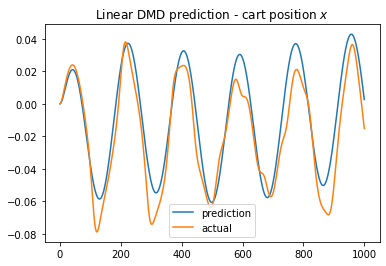

In [10]:
plt.plot(prediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"Linear DMD prediction - cart position $x$");

### Control-affine DMD predictor

Similarly to the `DMDControl` defined above, here we demonstrate the use the `gDMDAffine` class. Two main difference exist between the two:

1. The `gDMDAffine` class uses a Koopman generator definition, which in practice means that it supports irregular time samples and time steps in the training data different from the test.

1. Additionally, the `gDMDAffine` estimator finds the matrix $A$ and the tensor $B$ such that $\dot{z} = Az + \sum_{i=1}^{m}B_iu_iz$, i.e. it assumes the system is control input affine.

it should also be noted that, as a result of the implementation using adaptive time-step integration to find the generators, the `gDMDAffine` and classes using it can be significantly slower that the corresponding fixed-step methods.

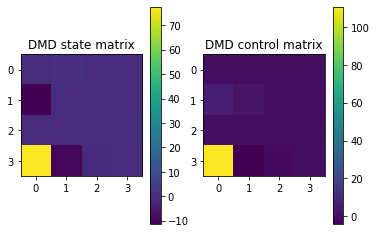

In [11]:
gdmda = gDMDAffine()
gdmda.fit(X_tsc[state_cols], U=X_tsc[control_cols])

m = gdmda.control_matrix_.shape[-1]
plt.subplot(1, 1 + m, 1)
plt.imshow(gdmda.sys_matrix_)
plt.colorbar()
plt.title("DMD state matrix")
for i in range(m):
    plt.subplot(1, 1 + m, 2 + i)
    plt.imshow(gdmda.control_matrix_[:, :, i])
    plt.colorbar()
    plt.title("DMD control matrix");

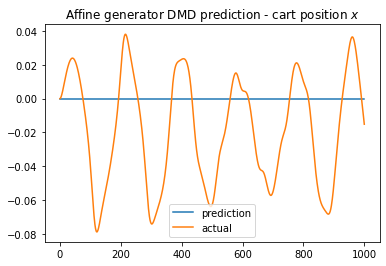

In [12]:
prediction = gdmda.predict(
    ic,
    U=control_input,
    time_values=t,
)
plt.plot(prediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"Affine generator DMD prediction - cart position $x$");

### EDMD Predictor
The EDMD approach uses a dictionary of lifting function to compute a finite-dimensional estimate for the Koopman operator of the underlying system using the available data. 

The `EDMDControl` class works similarly to the `DMDControl` class, but requires additionally that a lifting dictionary `dict_steps` is provided (see Tutorial 6 on EDMD for more further details). It is also important to provide the correct value of the `include_id_state` parameter depending on whether the dictionary natrually includes or not the original state - if the original state is included (e.g. when using transformers `TSCIdentity` or `TSCTakensEmbedding`, then `inculde_id_state=False`, but when using `TSCRadialBasis` -- `include_id_state=True`.)
The `EDMDControl` class also provides a `.transform` method to directly access the lifting function of the dictionary.

#### Using Identity dictionary
This is equivalent to using the DMD method, since the dictionary consists only of the original features. Here it is used to introduce the interface to the method. Here it can be seen that the split between state and control can also be provided to the `.fit` method (which is also the case for the `DMDControl` class).

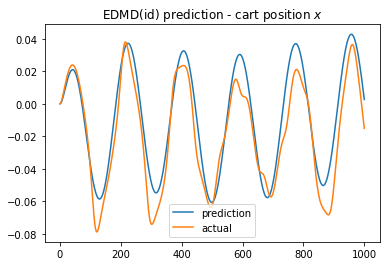

In [13]:
edmdid = EDMD(
    dict_steps=[
        ("id", TSCIdentity()),
    ],
    dmd_model=DMDControl(),
    include_id_state=False,
).fit(X_tsc[state_cols], X_tsc[control_cols])
idprediction = edmdid.predict(ic, U=control_input, time_values=t)
plt.plot(idprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(id) prediction - cart position $x$");

#### Using a realistic dictionary
Here we use a realistic dictionary of 100 randomly selected RBF centers from a inverse quadratic kernel. 

Please note that using `TSCRadialBasis` transofrmer with `center_type='fit_params'` requires passing the `centers` parameters to the `.fit` method of transformer using the `fit_params` as detailed in the documentation.

In [14]:
num_rbfs = 100
eps = 1

rbf = TSCRadialBasis(
    kernel=InverseQuadraticKernel(epsilon=eps), center_type="fit_params"
)
center_ids = sorted(
    np.random.choice(
        range(0, sim_num_steps * training_size), size=num_rbfs, replace=False
    )
)
centers = X_tsc.iloc[center_ids].values

##### Linear control

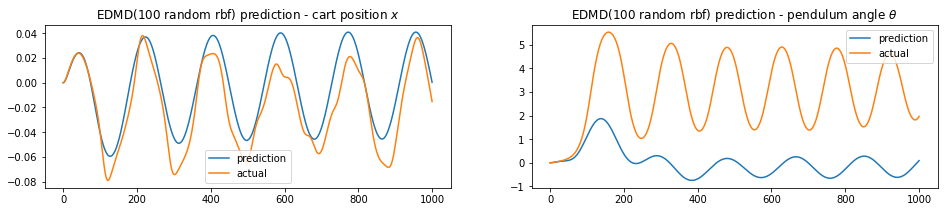

In [15]:
edmdrbf = EDMD(
    dict_steps=[("rbf", rbf)], dmd_model=DMDControl(), include_id_state=True
).fit(
    X_tsc[state_cols],
    X_tsc[control_cols],
    rbf__centers=centers[:, :-1],
)
rbfprediction = edmdrbf.predict(ic, U=np.atleast_2d(control_input).T, time_values=t)
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values, label="prediction")
plt.plot(dfx["theta"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");

In the figure above we can see the the EDMD using the linear DMD estimator predicts the displacement even better than the DMD, but the prediction for $\theta$ is good only on a short time scale.

##### Control-affine

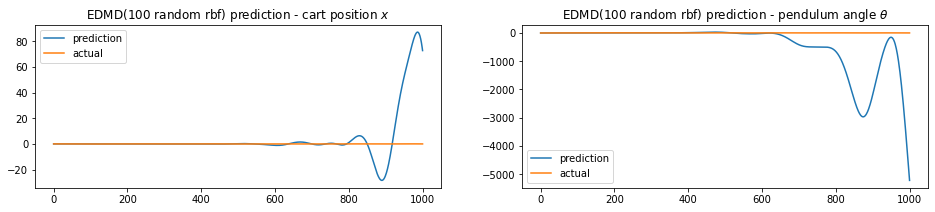

In [16]:
egdmdarbf = EDMD(
    dict_steps=[
        ("rbf", rbf),
    ],
    dmd_model=gDMDAffine(),
    include_id_state=True,
).fit(
    X_tsc[state_cols],
    X_tsc[control_cols],
    rbf__centers=centers[:, :-1],
)
rbfprediction = egdmdarbf.predict(ic, U=np.atleast_2d(control_input).T, time_values=t)
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values, label="prediction")
plt.plot(dfx["theta"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");

As we can see, the control-affine model becomes unstable, which suggests that its assumptions fit poorly the training data, or perhaps more training data is needed to learn the behaviour. Below we plot a shorter prediction period over which the estimator remains closer to the reference.

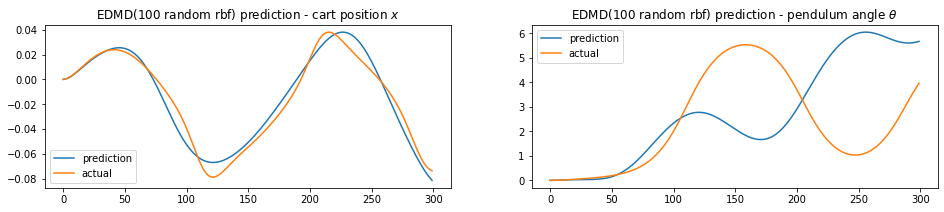

In [17]:
limit = 300
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values[:limit], label="prediction")
plt.plot(dfx["x"].values[:limit], label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values[:limit], label="prediction")
plt.plot(dfx["theta"].values[:limit], label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");

## Koopman Model Predictive Control

Model Predictive Control (MPC) is a method for estimating a control signal to provide to a system to achieve certain behaviour in the future. 

An important parameter for MPCs is the prediction horizon, which denotes how far in the future is the control signal computed. Here we set it to 100 timesteps (1 second). The optimality of the signal is computed using a cost function of the referenced states (`qois`) and the control signal itself. Here we provide both $x$ and $\theta$ as referenced states, but set the running cost weight of $\theta$ to 0 to showcase the functionality of the interface. Additionaly, the cost function enables penalizing control inputs. To match as well as possible the test data, this is set to a small value.

#### Linear KMPC
Here we show an implementation of a Koopman MPC (KMPC) where the model part is based on the Koopman operator. The `LinearKMPC` class implements such a controller based on the `EDMDControl` class illustrated above with `dmd_model=DMDControl()` (by default). The key benefit is that the model is a linear system in the lifted space and the optimal control can be directly computed using quadratic programming optimizer.

In [18]:
horizon = 100

kmpc = LinearKMPC(
    predictor=edmdrbf,
    horizon=horizon,
    state_bounds=np.array([[1, -1], [6.28, 0]]),
    input_bounds=np.array([[5, -5]]),
    qois=["x", "theta"],
    cost_running=np.array([100, 0]),
    cost_terminal=1,
    cost_input=0.001,
)

To generate the control signal, a full initial state is required, in addition to a reference to track. Here we use a reference  produced by a known control signal in the training data, so as to be able to later compare it to the optimal control signal computed by the controller.

In [19]:
reference = dfx[["x", "theta"]].iloc[: horizon + 1]
ukmpc = kmpc.generate_control_signal(rbfprediction.initial_states(), reference)

Further more, we compute what trajectory the model has predicted based on the control signal computed by the controller and what is the real response of the system.

In [20]:
kmpcpred = edmdrbf.predict(rbfprediction.initial_states(), U=ukmpc)
invertedPendulum.reset()
ukmpc_interp = interp1d(
    rbfprediction.time_values()[:horizon],
    ukmpc,
    axis=0,
    fill_value=0,
    bounds_error=False,
)
ukmpc_func = lambda t, y: ukmpc_interp(t)
kmpctraj = invertedPendulum.predict(
    time_step=sim_time_step,
    num_steps=horizon,
    control_func=ukmpc_func,
)
kmpctraj = pd.DataFrame(data=kmpctraj.T, columns=state_cols)

We now plot the data that we obtained from the `KoopmanMPC` class and compare the predicted trajectories for both position $x$ and angle $\theta$. In addition, we also compare the estimated control signal from the `KoopmanMPC` class and compare it with the the reference control signal above.

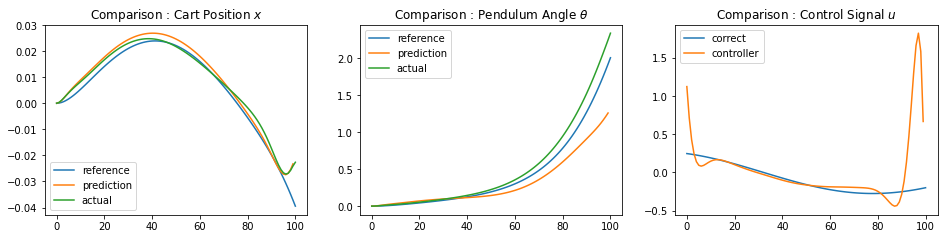

In [21]:
plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(dfx["x"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["x"].values, label="prediction")
plt.plot(kmpctraj["x"].values, label="actual")
plt.legend()
plt.title(r"Comparison : Cart Position $x$")
plt.subplot(132)
plt.plot(dfx["theta"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["theta"].values, label="prediction")
plt.plot(kmpctraj["theta"].values, label="actual")
plt.legend()
plt.title(r"Comparison : Pendulum Angle $\theta$")
plt.subplot(133)
plt.plot(dfu["u"].values[: horizon + 1], label="correct")
plt.plot(ukmpc, label="controller")
plt.legend()
plt.title(r"Comparison : Control Signal $u$");

#### Affine KMPC

Similarly to above, the `AffineKgMPC` class models the system based on `EDMDControl` class used with `dmd_model=gDMDAffine()`. This class however is much less efficient, since not only is the prediction slower, but the structure of the affine systems requires a slower quasi-Newton optimizer. Some differences in the interface are also present:

1. The `AffineKgMPC` class does not support applying bounds on the state, only on the input

1. Due to the above, the `qoi` parameter is not implemented independently. The effect of tracking only a subset of the state can be achieved by setting `cost_state` of the untracked parameters to 0.

1. Unlike in the `LinearKMPC` implementation, the cost of the state is the same over the whole horizon, and is not split between `cost_running` and `cost_terminal`

1. Time steps at which to generate the control signal are required, either as index if `reference` is a `TSCDataFrame`, or as a separte array as shown. Those can be again non-uniform.

In [22]:
horizon = 100

akgmpc = AffineKgMPC(
    predictor=egdmdarbf,
    horizon=horizon,
    input_bounds=np.array([[5, -5]]),
    cost_state=np.array([1, 0, 0, 0]),
    cost_input=0.001,
)

In [23]:
reference = dfx.values[: horizon + 1, :4].T
ukmpc = akgmpc.generate_control_signal(
    rbfprediction.initial_states(),
    reference,
    time_values=dfx.iloc[: horizon + 1].index,
)

In [24]:
kmpcpred = egdmdarbf.predict(rbfprediction.initial_states(), U=ukmpc)
invertedPendulum.reset()
ukmpc_interp = interp1d(
    rbfprediction.time_values()[:horizon],
    ukmpc,
    axis=0,
    fill_value=0,
    bounds_error=False,
)
ukmpc_func = lambda t, y: ukmpc_interp(t)
kmpctraj = invertedPendulum.predict(
    time_step=sim_time_step,
    num_steps=horizon,
    control_func=ukmpc_func,
)
kmpctraj = pd.DataFrame(data=kmpctraj.T, columns=state_cols)

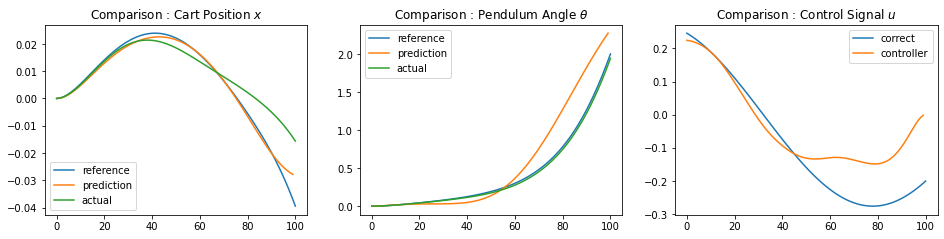

In [25]:
plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(dfx["x"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["x"].values, label="prediction")
plt.plot(kmpctraj["x"].values, label="actual")
plt.legend()
plt.title(r"Comparison : Cart Position $x$")
plt.subplot(132)
plt.plot(dfx["theta"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["theta"].values, label="prediction")
plt.plot(kmpctraj["theta"].values, label="actual")
plt.legend()
plt.title(r"Comparison : Pendulum Angle $\theta$")
plt.subplot(133)
plt.plot(dfu["u"].values[: horizon + 1], label="correct")
plt.plot(ukmpc, label="controller")
plt.legend()
plt.title(r"Comparison : Control Signal $u$");